In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from os import path
import matplotlib.pyplot as plt
from wordcloud import WordCloud,ImageColorGenerator,STOPWORDS
import cv2
from sklearn.cluster import KMeans
import pylab as pl
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

In [2]:
df=pd.read_csv("Chicago_Crimes_2012_to_2017.csv")

In [ ]:
df.Date=pd.to_datetime(df.Date,format='%m/%d/%Y %I:%M:%S %p')
df.index=pd.DatetimeIndex(df.Date)
df['time_hour']=df['Date'].apply(lambda x:x.hour)
df['month']=df['Date'].apply(lambda x:x.month)
df['year']=df['Date'].apply(lambda x:x.year)
df=df[df['year']!=2017]
df.head()

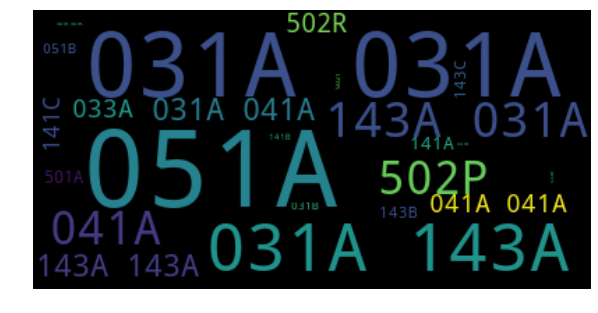

In [6]:
crime_types_code=" ".join(crime for crime in df["IUCR"])
crime_code_worldcloud=WordCloud().generate(crime_types_code)
plt.figure(figsize=[10,10])
plt.imshow(crime_code_worldcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
aa=df[df['IUCR']=="051A"]

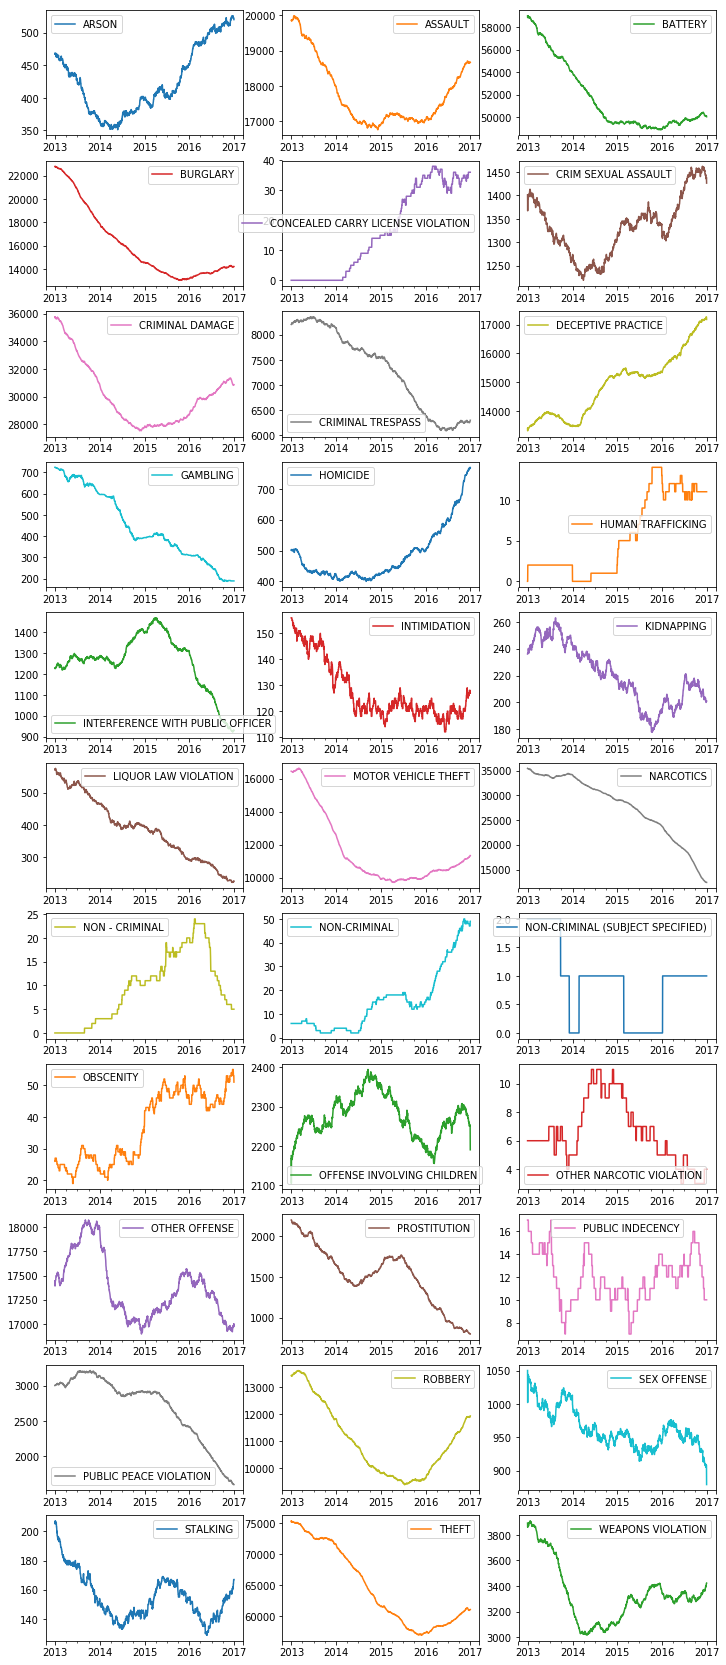

In [36]:
crimes_count_date=df.pivot_table('ID',aggfunc=np.size,columns='Primary Type',index=df.index.date,fill_value=0)
crimes_count_date.index=pd.DatetimeIndex(crimes_count_date.index)
plot=crimes_count_date.rolling(365).sum().plot(figsize=(12,30),subplots=True,layout=(-1,3),sharex=False,sharey=False)

In [37]:
sub_data = df[['Ward', 'IUCR', 'District']]
sub_data = sub_data.apply(lambda x:x.fillna(x.value_counts().index[0]))
sub_data['IUCR'] = sub_data.IUCR.str.extract('(\d+)', expand=True).astype(int)
sub_data.head()

,Ward,IUCR,District
Date,,,
2016-05-03 23:40:00,24.0,486,10.0
2016-05-03 21:40:00,20.0,486,3.0
2016-05-03 23:31:00,37.0,470,15.0
2016-05-03 22:10:00,28.0,460,15.0
2016-05-03 22:00:00,28.0,820,15.0


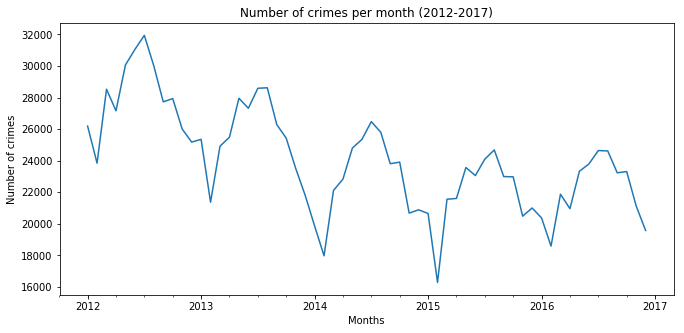

In [38]:
plt.figure (figsize=(11,5))

#resampling time series by months
df.resample ('M').size () .plot (legend=False)
plt.title ('Number of crimes per month (2012-2017)')
plt.xlabel ('Months')
plt. ylabel('Number of crimes')
plt.show()

In [39]:
#Just to see the overall crime trend by hourly period,we can see which times have the highest amount of crime
crimes_by_time=df.copy()

#Defining top 10 primary types
primary_types=["ARSON","CONCEALED CARRY LICENSE VIOLATION","CRIM SEXUAL ASSAULT","DECEPTIVE PRACTICE","HOMICIDE","ROBBERY","THEFT","WEAPONS VIOLATION","MOTOR VEHICLE THEFT","CRIMINAL DAMAGE"]

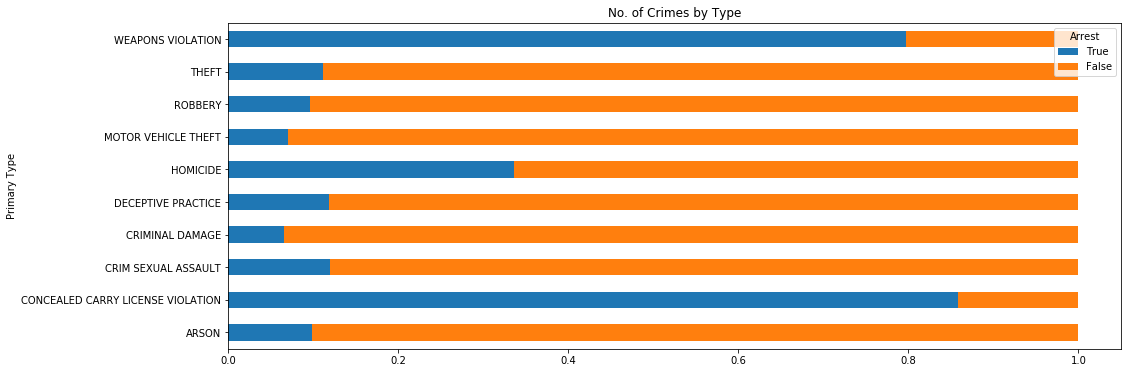

In [40]:
#Group by crime primary types and arrest
crimes_by_arrest = df.copy()
crimes_by_arrest = crimes_by_arrest.groupby(['Primary Type','Arrest']).size().reset_index(name='No. of Crimes')

# Filter for top 10 crime primary types mentioned earlier
crimes_by_arrest = crimes_by_arrest[crimes_by_arrest['Primary Type'].isin(primary_types)]

# Create pivot table
crimes_by_arrest_pivot = pd.pivot_table(crimes_by_arrest,index=['Primary Type'],columns=['Arrest'], values="No. of Crimes",aggfunc=np.sum)
crimes_by_arrest_pivot = crimes_by_arrest_pivot.reset_index()

#Create new columns in pivot table: ["Total No."],"True", "False"
crimes_by_arrest_pivot['Total No']=crimes_by_arrest_pivot[True]+crimes_by_arrest_pivot[False]
crimes_by_arrest_pivot['True']= crimes_by_arrest_pivot[True]/crimes_by_arrest_pivot['Total No']
crimes_by_arrest_pivot['False'] = crimes_by_arrest_pivot[False]/crimes_by_arrest_pivot['Total No']
crimes_by_arrest_pivot = crimes_by_arrest_pivot[['Primary Type','True','False']]
crimes_by_arrest_pivot = crimes_by_arrest_pivot.set_index('Primary Type')

#plot stacked bar chart of Arrest success for the 10 different crimes
crimes_by_arrest_pivot.plot(kind='barh', stacked=True, figsize = (16,6), title="No. of Crimes by Type")

In [41]:
km = KMeans(n_clusters=4)
km.fit(sub_data)
y = km.predict(sub_data)
labels = km.labels_
sub_data['Cluster'] = y

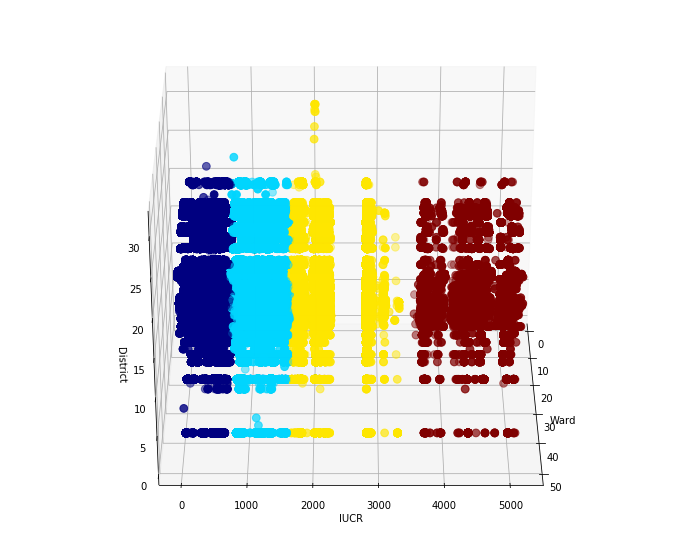

In [43]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
x = np.array(sub_data['Ward'])
y = np.array(sub_data['IUCR'])
z = np.array(sub_data['District'])

ax.set_xlabel('Ward')
ax.set_ylabel('IUCR')
ax.set_zlabel('District')

ax.scatter(x,y,z, marker="o", c = sub_data["Cluster"], s=60, cmap="jet")
ax.view_init(azim=0)
#print(ax.azim)
plt.show()

In [ ]:
crime_data=pd.read_csv("Chicago_Crimes_2012_to_2017.csv")

In [13]:
crime_data = crime_data.dropna()
crime_data.isnull().sum().sum()
keep_cols = ['Arrest','Primary Type','Domestic','District','Location Description','X Coordinate','Y Coordinate']
crime_data = crime_data[keep_cols].reset_index()
crime_data.head()

,index,Arrest,Primary Type,Domestic,District,Location Description,X Coordinate,Y Coordinate
0,0,True,BATTERY,True,10.0,APARTMENT,1154907.0,1893681.0
1,1,False,BATTERY,True,3.0,RESIDENCE,1183066.0,1864330.0
2,2,False,PUBLIC PEACE VIOLATION,False,15.0,STREET,1140789.0,1904819.0
3,3,False,BATTERY,False,15.0,SIDEWALK,1143223.0,1901475.0
4,4,False,THEFT,True,15.0,RESIDENCE,1139890.0,1901675.0


In [87]:
percentage_intances = crime_data.groupby('Arrest').size() * 100 / len(crime_data)
print(percentage_intances)
print("------------------")
print("Percentage Positive Instance = {}\nPercentage Negative Instance = {} ".format(percentage_intances[1],percentage_intances[0]))

Arrest
False    73.839103
True     26.160897
dtype: float64
------------------
Percentage Positive Instance = 26.160896525224466
Percentage Negative Instance = 73.83910347477553 


In [61]:
len(crime_data['Location Description'].unique().tolist())

140

In [14]:
X=crime_data.drop('Arrest',axis=1)
features = list(X.columns)
y = crime_data["Arrest"]

In [15]:
X.head()

,index,Primary Type,Domestic,District,Location Description,X Coordinate,Y Coordinate
0,0,BATTERY,True,10.0,APARTMENT,1154907.0,1893681.0
1,1,BATTERY,True,3.0,RESIDENCE,1183066.0,1864330.0
2,2,PUBLIC PEACE VIOLATION,False,15.0,STREET,1140789.0,1904819.0
3,3,BATTERY,False,15.0,SIDEWALK,1143223.0,1901475.0
4,4,THEFT,True,15.0,RESIDENCE,1139890.0,1901675.0


In [16]:
labelencoder = LabelEncoder()
X['Primary Type']=X['Primary Type'].astype("category").cat.codes
X['Location Description']=X['Location Description'].astype("category").cat.codes

In [17]:
scaler = preprocessing.MinMaxScaler()
X[['X Coordinate', 'Y Coordinate']] = scaler.fit_transform(X[['X Coordinate', 'Y Coordinate']])

In [18]:
X.head()

,index,Primary Type,Domestic,District,Location Description,X Coordinate,Y Coordinate
0,0,2,True,10.0,17,0.958334,0.970336
1,1,2,True,3.0,109,0.981701,0.955296
2,2,27,False,15.0,125,0.946619,0.976043
3,3,2,False,15.0,121,0.948639,0.974329
4,4,31,True,15.0,109,0.945873,0.974432


In [99]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X,y)
predicted = dt_clf.predict(X[features])
recall_score = metrics.recall_score(crime_data['Arrest'], predicted)
precision_score = metrics.precision_score(crime_data['Arrest'], predicted)
accuracy_score = metrics.accuracy_score(crime_data['Arrest'], predicted)
print("Training Accuracy = {} Precision = {} Recall = {}".format(accuracy_score,precision_score,recall_score))

Training Accuracy = 1.0 Precision = 1.0 Recall = 1.0


In [100]:
for depth in range(1,10):
    tree_clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
    if tree_clf.fit(X,y).tree_.max_depth < depth:
        break
    score = np.mean(cross_val_score(tree_clf, X, y,scoring='accuracy', cv=10, n_jobs=1))
    print("Depth: %i Accuracy: %.3f" % (depth,score))

Depth: 1 Accuracy: 0.738
Depth: 2 Accuracy: 0.774
Depth: 3 Accuracy: 0.807
Depth: 4 Accuracy: 0.787
Depth: 5 Accuracy: 0.751
Depth: 6 Accuracy: 0.731
Depth: 7 Accuracy: 0.715
Depth: 8 Accuracy: 0.699
Depth: 9 Accuracy: 0.675


In [103]:
dt_clf = DecisionTreeClassifier(max_depth=3)
dt_clf.fit(X,y)
predicted = dt_clf.predict(X[features])
dt_recall = metrics.recall_score(crime_data['Arrest'], predicted)
dt_precision = metrics.precision_score(crime_data['Arrest'], predicted)
dt_accuracy= metrics.accuracy_score(crime_data['Arrest'], predicted)
print("Accuracy for DT =",dt_accuracy)
print("Precision for DT =",dt_precision)
print("Recall for DT =",dt_precision)

Accuracy for DT = 0.8368036436319283
Precision for DT = 0.9701382947908738
Recall for DT = 0.9701382947908738


In [105]:
importances=dt_clf.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
# We have taken the top 5 feature 
print("The main features used for classification")
print(X.columns[indices[:5]])
print("Top main feature is",X.columns[indices[:1]][0])

Feature ranking:
The main features used for classification
Index(['Primary Type', 'Domestic', 'index', 'Y Coordinate', 'X Coordinate'], dtype='object')
Top main feature is Primary Type


In [107]:
# Applying 10 fold cross validation
dt_cv_accuracy = cross_val_score(dt_clf, X, y, cv=10).mean()
dt_cv_precision= cross_val_score(dt_clf, X, y, cv=10, scoring='precision').mean()
dt_cv_recall = cross_val_score(dt_clf, X, y, cv=10, scoring='recall').mean()
print("Cross Validation Accuracy DT:", dt_cv_accuracy)
print("Cross Validation Recall DT:", dt_cv_precision)
print("Cross Validation Precision DT:", dt_cv_recall)

Cross Validation Accuracy DT: 0.8070109306468967
Cross Validation Recall DT: 0.9044432121362369
Cross Validation Precision DT: 0.41181743219781686


In [117]:
# Using GaussianNB
gaussian_clf = GaussianNB()
gaussian_clf.fit(X, y)

# Applying 10 fold cross validation
gaussian_accuracy = cross_val_score(gaussian_clf, X, y, cv=10).mean()
gaussian_precision= cross_val_score(gaussian_clf, X, y, cv=10, scoring='precision').mean()
gaussian_recall = cross_val_score(gaussian_clf, X, y, cv=10, scoring='recall').mean()
print("Accuracy for gaussian :", gaussian_accuracy)
print("Recall for gaussian:", gaussian_recall)
print("Precision for gaussian:", gaussian_precision)

C:\Users\Pushkar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Pushkar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Pushkar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Pushkar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Pushkar\Anaconda3\lib\site-packages\sklearn\metrics\classification.

Accuracy for gaussian : 0.7383910347567004
Recall for gaussian: 0.0
Precision for gaussian: 0.0
